## IoU demo
#### This is a demo to help you gain a better insight about the 2d stitching inner workings and in particular the intersection over union metric 

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import watershed_3d as ws
from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import tifffile as tif

DIPlib -- a quantitative image analysis library
Version 3.4.1 (Oct 13 2023)
For more information see https://diplib.org


In [2]:
def square(canvas, centre, side_length, label = 255):
    """
    Draws a square centered at 'centre' with side length 'side_length'
    and colour 'label'. The colour is a shade of grey, ie it takes
    values between 0 (pure black) and 255 (pure white) and also serves
    as the label of the shape
    The square is drawn on a background defined by 'canvas'
    """
    row, col = centre
    size = int(side_length/2)
    H, W = canvas.shape
    hmin = max(0, row-size)
    hmax = min(H, 1 + row+size)

    wmin = max(0, col-size)
    wmax = min(W, 1 + col+size)

    canvas[hmin:hmax, wmin:wmax] = label
    return canvas.astype(np.uint8)

In [3]:
def checkerboard():
    """
    Helper function to draw multiple shapes on a common background
    """
    x = np.zeros([600, 600])
    x = square(canvas=x, centre=(150, 150), side_length=200, label=40)
    x = square(canvas=x, centre=(150, 450), side_length=220, label=80)
    x = square(canvas=x, centre=(450, 150), side_length=240, label=120)
    x = square(canvas=x, centre=(450, 450), side_length=260, label=170)

    return x

## IoU: Intro

We use the intersection over union metric to decide whether two overlapping shapes can be deemed as one single entity or not

To demontrate this graphically lets draw two squares:

In [4]:
def two_squares(stitch_threshold=0.15):
    background_sq = square(canvas=np.zeros([600, 600]), centre=(150, 150), side_length=200, label=40)

    foreround_sq = square(canvas=np.zeros(background_sq.shape), centre=(250, 250), side_length=200, label=255)
    masks = np.stack([foreround_sq, background_sq])
    stitched = ws.segment.stitch3D_coo(masks, stitch_threshold=stitch_threshold)

    out = stitched.max(axis=0)
    out = out.astype(np.uint8)
    # tif.imwrite("out.tif", out)
    img = Image.fromarray(out)
    return img

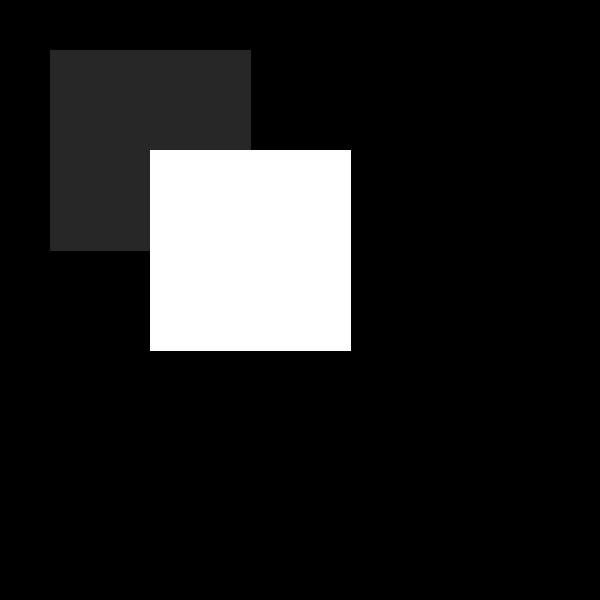

In [5]:
two_squares()

The dark grey square in the background is centered at point = (150, 150) and each side has length = 200. Additionally, the white square has the same side length as the grey square (ie 200) but it centered at (250, 250)


Hence the overlap region is a small square with side length = 100. Its area is: 

Interesection area = 100 * 100 = 10000



The union of the two squares has an area equal to the sum of the two individual squares minus the overlap (otherwise we will be double-counting the common part). Hence the union is equal to:

Union area = (200 * 200 + 200 * 200 - 100*100)

Therefore the IoU metric is:



\begin{align}
IoU & = \frac{Interesection}{Union} \\
& = \frac{100*100}{200 * 200 + 200 * 200 - 100*100} \\
& = \frac{10000}{70000} \\
& = 0.14285
\end{align}

The IoU metric in general, ranges between 0 (when there is no overlap at all) and 1 (when the shapes exactly overimpose each other)

For the specific example above IoU = 0.14. In our watershed 2d-sticher there is a argument that you can pass called 'stitch_threshold'. 

<font color='red'>If the IoU is greater that this threshold then the two shapes are merged otherwise they are left unchanged</font>

You can use the slider below to change the threshold. You will notice that as soon as the threshold falls below 0.14 the two shapes take the same colour, meaning that they now have the same label. In particular, the label of the shape in the background is replaced by the label of the foreground shape 

In [6]:
@interact(stitch_threshold=(0.0, 1.0, 0.005))
def demo(stitch_threshold=0.5):
    return two_squares(stitch_threshold=stitch_threshold)

interactive(children=(FloatSlider(value=0.5, description='stitch_threshold', max=1.0, step=0.005), Output()), …

## IoU: Second example

Lets now do a slightly more complicated case where we have again one single square in the foregound (placed at the centre of our canvas and bigger than previously) and 4 smaller ones in the backgound

In [7]:
def app(stitch_threshold=0.15):
    four_squares = checkerboard()
    my_square = square(canvas=np.zeros(four_squares.shape), centre=(300, 300), side_length=300, label=255)
    masks = np.stack([my_square, four_squares])
    stitched = ws.segment.stitch3D_coo(masks, stitch_threshold=stitch_threshold)

    out = stitched.max(axis=0)
    out = out.astype(np.uint8)
    # tif.imwrite("out.tif", out)
    img = Image.fromarray(out)
    return img


<font font-weight='bold' color='red'>Christina, play around with the slider. As you get closer to zero you will see the squares in the backgound changing color as the threshold takes values that are lower than the actual IoU </font>


In [8]:
@interact(stitch_threshold=(0.0, 1.0, 0.005))
def demo(stitch_threshold=0.5):
    return app(stitch_threshold=stitch_threshold)

interactive(children=(FloatSlider(value=0.5, description='stitch_threshold', max=1.0, step=0.005), Output()), …

**Note:**

The example above can be seen from a perspective where you have a microglia in the first plane, and splits into four smaller parts in the second plane. Depending on the treshold you can relay the label of the microglia in the foreground to none, 1, 2,3 or all four shapes in the second plane.

In cellpose the logic is a bit different. Under cellpose even you push the slider above all the way left, to zero, you would only have just one square of the squares in the second plane changing colour.
If the IoU is greater the threshold, and you have more than one cell satisfying this condition, cellpose will pass the label to the biggest shape and only to that.